In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy
%matplotlib inline
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['figure.dpi'] = 75
import seaborn as sns
from scipy import stats, log
import scipy.stats as stats
from statsmodels.sandbox.stats.multicomp import multipletests


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 3.A

#### preprocess done on the file: 
Removed all the rows that contains !. and started working on the file from line starting with Class.

Then I collected from each line the first item and set that as header for the column

In [ ]:
#local file
df = pd.read_csv('AMI_GSE66360_series_matrix.csv', index_col=0, header=None).T
df

Saving AMI_GSE66360_series_matrix.csv to AMI_GSE66360_series_matrix.csv


NameError: ignored

In [ ]:
# drive
#from google.colab import files 
#uploaded = files.upload()
# drive




"""
import io 

df = pd.read_csv(io.BytesIO(uploaded['AMI_GSE66360_series_matrix.csv']),skiprows=59).T
df = df.reset_index()
df.columns = df.iloc[0]
df = df.drop(df.index[0])
for i in range(1,len(df['Class'])+1):
    df['Class'][i] =df['Class'][i][0:1:1] 

df
"""

#### 1 + 2
#### 1) How many genes profiled?
#### 2) How many samples (subjects/patients) in total?

In [ ]:
print(f"Number of genes: {df.iloc[:,2:].shape[1]}, number of patients: {df.iloc[:,2:].shape[0]}")

Number of genes: 54675, number of patients: 99


#### 3) How many samples in each class?

In [ ]:
df["Class"].value_counts()

H    50
M    49
Name: Class, dtype: int64

#### 4) If there are missing values, then remove the entire row (gene) from the data matrix. How many rows left now?

In [ ]:
df.dropna(axis='columns',inplace=True) #Removing columns instead of rows because columns are genes.
number_of_genes = df.shape[1]
print(f"Number of genes: {number_of_genes-2}") # the -2 is to remove the 2 columns that are Class & ID_REF

Number of genes: 54628


### 5) Pick 20 genes at random. Draw histograms comparing. expression levels of each of these genes in the two classes M and H.

In [ ]:
import random
num_to_select = 20
random.seed(24)
genes_index_random_picked = random.sample(list(range(number_of_genes)), num_to_select)

In [ ]:
df_20_genes_samples = df.iloc[:, [0] + genes_index_random_picked].copy()
cols = list(df_20_genes_samples.columns)
cols.remove('Class')
# for col in cols:
#     df_20_genes_samples[col] = df_20_genes_samples[col].astype(float)
    
classes = df_20_genes_samples.iloc[:,0]
H_vector = classes == "H"
M_vector = classes == "M"
df_20_genes_samples_class_H = df_20_genes_samples[H_vector]
df_20_genes_samples_class_M = df_20_genes_samples[M_vector]


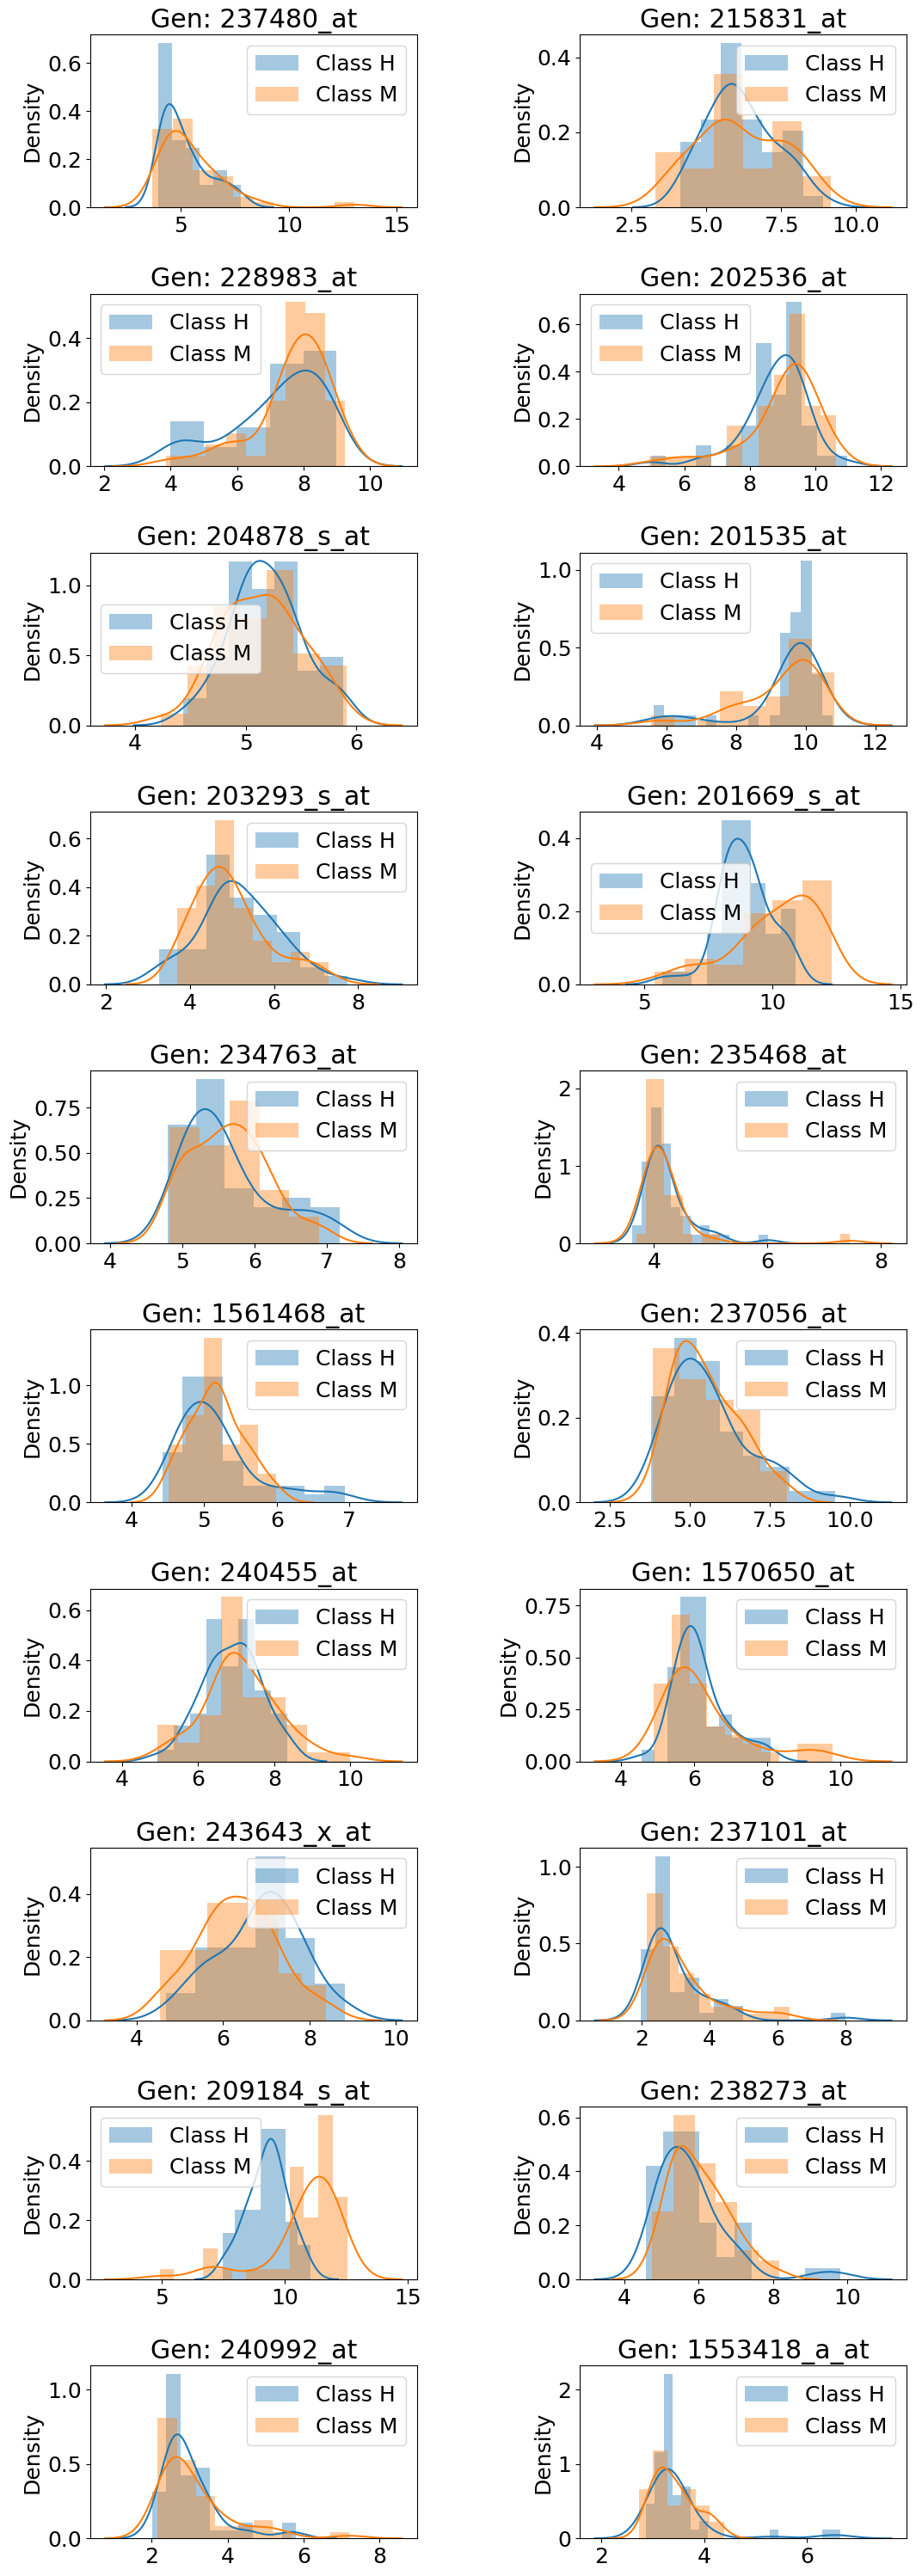

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import random
import numpy
from matplotlib import pyplot
import seaborn as sns
plt.rcParams['figure.figsize'] = [10, 32]
plt.rcParams['figure.dpi'] = 100

fig = plt.figure()
fig.subplots_adjust(top=0.92, bottom=0.01, left=0.0010, right=0.95, hspace=0.5, wspace=0.5)

for idx, col in enumerate(cols, start=1):
    ax = fig.add_subplot(10, 2, idx)
    h_values = df_20_genes_samples_class_H[col].to_numpy()
    m_values = df_20_genes_samples_class_M[col].to_numpy()    
    sns.distplot(h_values, ax=ax, label='Class H').set_title(f"Gen: {col}")
    sns.distplot(m_values, ax=ax, label='Class M')
    plt.legend() 


## 3.B


In [ ]:
classes = df.iloc[:,0]
M_vector = classes == "M"
H_vector = classes == "H"

max_rank = 0
def calculate_RS(g):
    global max_rank
    ranks = g.rank()
    if max_rank < ranks[M_vector].sum():
        max_rank = ranks[M_vector].sum()
    return ranks[M_vector].sum()

ranked_df = df.iloc[:,2:].apply(calculate_RS, axis=0)
ranked_values = ranked_df.to_numpy()


### 1) Consider some gene, g. Under the null model (which assumes that for g there is no M vs H DE), what is the expected sum of ranks of g’s expression levels measured for samples labeled M?

According to the data, N=99, B=49 and so $E\left(RS\left(g\right)\right)={B(N+1) \over 2} = {49(99+1) \over 2} = 2450$ 

### 2) Denote this sum of ranks by RS(g). What is the maximal value, c, that RS(g) can take?

If all M class are ordered together at the bottom, then the sum of 49 (number of samples with class M) rankes from 51 to 99 is: $\sum_{i=49}^{99}i=3675$, the empirical expected value is: 3549

### Solved 3 + 4 together

### 3) Under the null model, what is the probability of RS(g) = c? (provide a formula for this and explain it)
## 4) Under the null model, what is the probability of RS(g) = c-1? what is the probability of RS(g) = c-2? (provide formulas and explain them)

To solve this, we will use the formula for normal approximation we saw in class: $Z(T) = {T-\mu \over \sigma}$, and then calc probability on it.
We found in 3.B.2 that $\mu = 2450$, so now, we need to find $\sigma$, we will use the formula we saw in class: $\sigma = \sqrt{B(N-B)(N+1) \over 12} = \sqrt{49(99-49)(99+1) \over 12} = 142.887$.    
And so for $P\left(T=C\right)$, when C=3675, we get:         
$Z\left(C+1\right) = Z\left(3676\right) = {3676-\mu \over \sigma} = 8.58$  
$Z\left(C\right) = Z\left(3675\right) = {3675-\mu \over \sigma} = 8.573$    
$Z\left(C-1\right) = Z\left(3674\right) = {3674-\mu \over \sigma} = 8.5662$    
$Z\left(C-2\right) = Z\left(3673\right) = {3673-\mu \over \sigma} = 8.559$    
  
$ P\left(T=C\right) = P\left(T=3675\right) = P\left(T \ge 3675\right) - P\left(T \ge 3676\right) = P\left(Z(T) \ge 8.573\right) - P\left(Z(T) \ge 8.58\right) = 1-norm\_cdf(8.573) - (1-norm\_cdf(8.58)) = 2.97e-19 $

$ P\left(T=C-1\right) = P\left(C-1 \leq T < C\right) = P(T \geq C-1) - P(T \geq C) = P(T \geq 3674) - P(T \geq 3675) = P\left(Z(T) \ge 8.5662\right) - P\left(Z(T) \ge 8.573\right) = 1-norm\_cdf(8.5732) - (1-norm\_cdf(8.573)) = 3.15288e-19 $

$ P\left(T=C-2\right) = P\left(C-2 \leq T < C-1\right) = P(T \geq C-2) - P(T \geq C-1) = P(T \geq 3673) - P(T \geq 3674) = P\left(Z(T) \ge 8.559\right) - P\left(Z(T) \ge 8.5662\right) = 1-norm\_cdf(8.559) - (1-norm\_cdf(8.5662)) = 3.348e-19 $    
    
Conclusion:    
$ P\left(T=C\right) = 2.97e-19 $      
$ P\left(T=C-1\right) = 3.15288e-19 $    
$ P\left(T=C-2\right) = 3.348e-19 $       

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


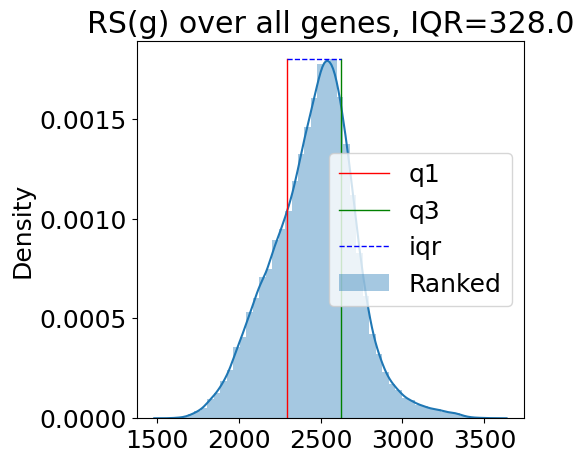

In [ ]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.rcParams['figure.dpi'] = 100

classes = df.iloc[:,0]
M_vector = classes == "M"
H_vector = classes == "H"

# First quartile (Q1) 
Q1 = np.percentile(ranked_values, 25, interpolation = 'midpoint') 
  
# Third quartile (Q3) 
Q3 = np.percentile(ranked_values, 75, interpolation = 'midpoint')

fig = plt.figure() 
sns.distplot(ranked_values, label='Ranked').set_title(f"RS(g) over all genes, IQR={Q3-Q1}")
plt.plot([Q1, Q1], [0, 0.0018], linewidth=1, color="red", label='q1')
plt.plot([Q3, Q3], [0, 0.0018], linewidth=1, color="green", label='q3')
plt.plot([Q1, Q3], [0.0018, 0.0018], "b--", linewidth=1 , label='iqr')
plt.legend() 

## 3.C

### WRS

In [ ]:
#from icecream import ic
from scipy.stats import norm
import math

alpha = 0.07


def calc_wilcoxon(a_b):
    a_b_sorted = sorted(a_b, key = lambda x: x[0], reverse=True)
    a_b_ranked_sorted = [(idx, ab[1]) for idx, ab in enumerate(a_b_sorted, start=1)]
    
    B = sum([x[1] for x in a_b_ranked_sorted])
    N = len(a_b_ranked_sorted)    
    mu_t = B*(N+1)/2
    sigma_t = round(math.sqrt((B*(N-B)*(N+1))/12), 2)    
    Z = lambda T: (T - mu_t)/sigma_t
    T = sum([t[0] for t in a_b_ranked_sorted if t[1]])
    Z_t = round(Z(T),2)
    
    return norm.cdf(Z(T)), norm.sf(Z(T))


df_x = df.copy()
Binary_series = df_x["Class"].apply(lambda x: 1 if x == "H" else 0)


def tuple_it(g):
    return list(zip(g,Binary_series))


df_x = df_x.iloc[:,2:].apply(tuple_it, axis=0)
df_WRS = df_x.apply(calc_wilcoxon, axis=0, result_type="expand")


print(f'There are {df_WRS.T.iloc[:,1][df_WRS.T.iloc[:,1] <= alpha].shape[0]} overexpressed, {df_WRS.T.iloc[:,0].T[df_WRS.T.iloc[:,0] <= alpha].shape[0]} underexpressed genes using WRS.')

There are 10771 overexpressed, 10621 underexpressed genes using WRS.


### T-Test

In [ ]:
def calc_ttest(a_b):
    h_samples = [x[0] for x in a_b if x[1] == 1]
    m_samples = [x[0] for x in a_b if x[1] == 0]
    var = stats.ttest_ind(m_samples, h_samples)[0]
    
    return stats.t.cdf(var, df=degrees_of_freedom), stats.t.sf(var, df=degrees_of_freedom)

In [ ]:
degrees_of_freedom = df.shape[0] - 2


def calc_ttest(a_b):
    h_samples = [x[0] for x in a_b if x[1] == 1]
    m_samples = [x[0] for x in a_b if x[1] == 0]
    var = stats.ttest_ind(m_samples, h_samples)[0]
    
    return stats.t.cdf(var, df=degrees_of_freedom), stats.t.sf(var, df=degrees_of_freedom)


df_x = df.copy()
Binary_series = df_x["Class"].apply(lambda x: 1 if x == "H" else 0)


def tuple_it(g):
    return list(zip(g,Binary_series))


df_x = df_x.iloc[:,2:].apply(tuple_it, axis=0)
df_TTEST = df_x.apply(calc_ttest, axis=0, result_type="expand")


print(f'There are {df_TTEST.T.iloc[:,1][df_TTEST.T.iloc[:,1] <= alpha].shape[0]} overexpressed, {df_TTEST.T.iloc[:,0].T[df_TTEST.T.iloc[:,0] <= alpha].shape[0]} underexpressed genes using TTest.')

TypeError: ignored

##3.D 


###1-5

Text(0.5, 1.0, 'Kendall correlations in all pairs within D')

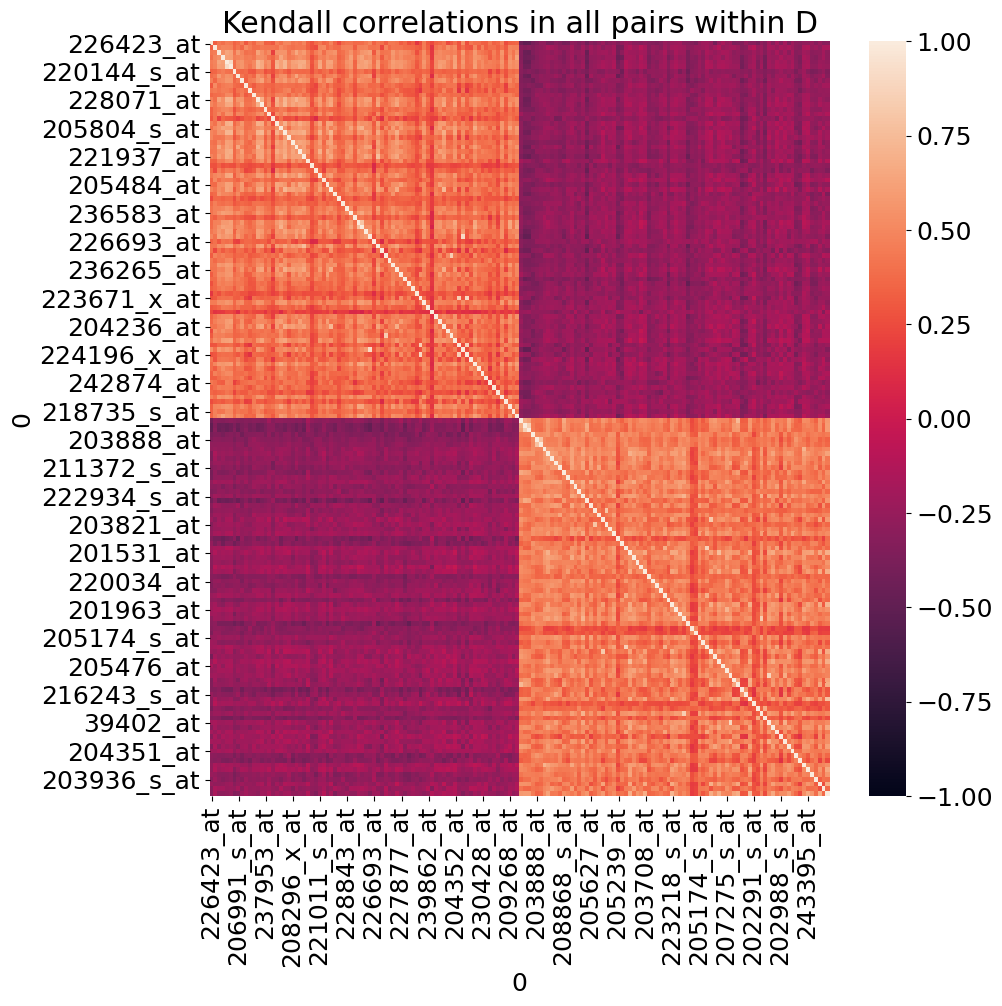

In [ ]:
underexpressed = df_WRS.T.iloc[:,0].T[df_WRS.T.iloc[:,0] <= alpha]
overexpressed = df_WRS.T.iloc[:,1][df_WRS.T.iloc[:,1] <= alpha]

underexpressed = underexpressed.sort_values()[:80]
overexpressed = overexpressed.sort_values()[:80]

pvalues160 = underexpressed.append(overexpressed)

D = df[pvalues160.index].astype("float")



corrD = D.corr(method="kendall")


plt.figure(figsize=(10, 10))
sns.heatmap(corrD, vmin=-1, vmax=1)

plt.title('Kendall correlations in all pairs within D')

In [ ]:
print("The expected values of the correlation under the assumption that the genes are pairwise  independent is 0")

print(f"the observed  mean is: {corrD.mean().mean()}")

The expected values of the correlation under the assumption that the genes are pairwise  independent is 0
the observed  mean is: 0.09149862628842582


In [ ]:
cols = pd.DataFrame(columns = D.columns)
pvaluesD = cols.T.join(cols, how='outer')

for i in cols:
        for j in cols:
            pvaluesD[i][j] = stats.kendalltau(D[i], D[j])[1]


numberOfPairs = scipy.special.comb(160,2) # 160 choose 2
alphaPairs = (np.sum(pvaluesD[pvaluesD < alpha].count()) - 160)/2 # removing 160 same values pairs and mirroring pairs
print(f"There are {numberOfPairs} pairs.")
print(f"While {alphaPairs} are significant (with alpha = {alpha}).")


There are 12720.0 pairs.
While 12444.0 are significant (with alpha = 0.07).


In [ ]:
rankD = pvaluesD.rank()
FDR = pvaluesD * 160 / rankD

FDRalpha = FDR <=0.05
print(f'There are {math.floor((FDRalpha.sum().sum()-160)/2)} co-expressed pairs with FDR <= 0.05.')


There are 12313 co-expressed pairs with FDR <= 0.05.


Using 160 genes instead of 54628 is obviously faster and easier to calculate, especially since we need to calculate for each pair in those genes.
yet, using the most significant parts of the data mean that the rest isn't taken account for, this can affect precision though the accuracy should be very close.

### 6

While 6052.0 are significant (with alpha = 0.07) restricting attention only to samples labeled M.
There are 4941 co-expressed pairs.


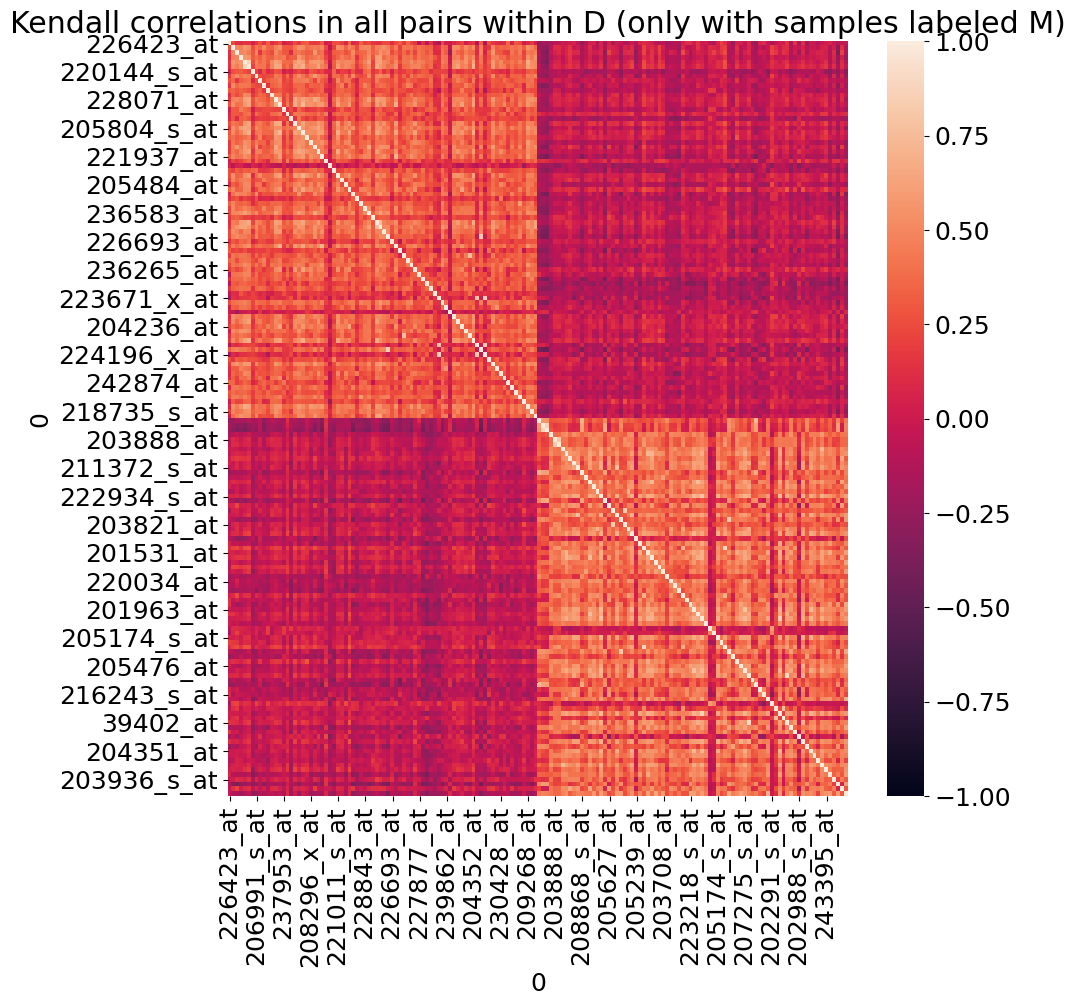

In [ ]:
DM = D[M_vector]

corrDM = DM.corr(method="kendall")

DMcols = pd.DataFrame(columns = DM.columns)
pvaluesDM = DMcols.T.join(DMcols, how='outer')

for i in cols:
        for j in cols:
            pvaluesDM[i][j] = stats.kendalltau(DM[i], DM[j])[1]

alphaPairsDM = (np.sum(pvaluesDM[pvaluesDM < alpha].count()) - 160)/2 # removing 160 same values pairs and mirroring pairs

print(f"While {alphaPairsDM} are significant (with alpha = {alpha}) restricting attention only to samples labeled M.")

plt.figure(figsize=(10, 10))
sns.heatmap(corrDM, vmin=-1, vmax=1)

plt.title('Kendall correlations in all pairs within D (only with samples labeled M)')


rankDM = pvaluesDM.rank()
FDR_DM = pvaluesDM * 160 / rankDM

FDRalphaDM = FDR_DM <=0.05
print(f'There are {math.floor((FDRalphaDM.sum().sum()-160)/2)} co-expressed pairs.')



Here we have fewer significant pairs and even fewer with FDR lower than 0.05.

With H and M : 12444 out of 12720 are significant, and 12313 with FDR <= 0.05

--> 12313/12444 = 98.9%

with M only : 6052 out of 12720 are significant, and 4941 with FDR <= 0.05

--> 4941/6052 = 81.6%

Since the whole group is labeled M, removing a control group, the likelyhood of finding a false pair is higher making the ratio lower.  

##3.E

In [ ]:
df_WRS.T[0]


0
1007_s_at          0.153446
1053_at            0.859428
117_at             0.999835
121_at             0.735605
1255_g_at          0.849843
                     ...   
AFFX-ThrX-5_at     0.988740
AFFX-ThrX-M_at     0.986255
AFFX-TrpnX-3_at    0.942330
AFFX-TrpnX-5_at    0.929173
AFFX-TrpnX-M_at    0.952798
Name: 0, Length: 54628, dtype: float64

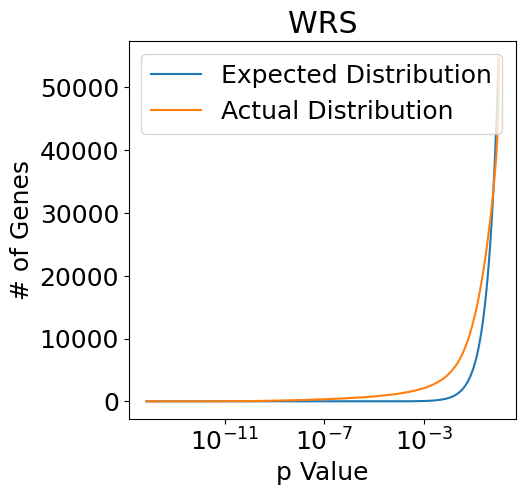

In [ ]:
toPlotWRS = pd.DataFrame()
toPlotWRS['p Value'] = df_WRS.T.iloc[:,1]
toPlotWRS['Expected Distribution'] = df_WRS.T.iloc[:,1]*(number_of_genes)
toPlotWRS["Actual Distribution"] = df_WRS.T.iloc[:,0].rank(ascending = False)   

ax = toPlotWRS[["Expected Distribution", "Actual Distribution", "p Value"]]
ax = ax.sort_values(by = "p Value").plot(x = "p Value")
ax.set_title('WRS')
ax.legend(loc = 'upper left')
ax.set_xscale("log")
plt.ylabel("# of Genes")
plt.show()

In [ ]:
toPlotTTest = pd.DataFrame()
toPlotTTest['p Value'] = df_TTEST.T.iloc[:,1]
toPlotTTest['Expected Distribution'] = df_TTEST.T.iloc[:,1]*(number_of_genes)
toPlotTTest["Actual Distribution"] = df_TTEST.T.iloc[:,0].rank(ascending = False)   

ax = toPlotTTest[["Expected Distribution", "Actual Distribution", "p Value"]]
ax = ax.sort_values(by = "p Value").plot(x = "p Value")
ax.set_title('T Test')
ax.legend(loc = 'upper left')
ax.set_xscale("log")
plt.ylabel("# of Genes")
plt.show()

In [ ]:
print("WRS:")
toTest = [0.05 , 0.01 , 0.005]
for FDRValue in toTest:
        reject , _ , _ , _ = multipletests(df_WRS.T.iloc[:,1], alpha=FDRValue, method='fdr_bh')
        print(f"  FDR = {FDRValue}  ")
        print(f"        # of Genes = {np.count_nonzero(reject)}")
print("T Test:")
toTest = [0.05 , 0.01 , 0.005]
for FDRValue in toTest:
        reject , _ , _ , _ = multipletests(df_TTEST.T.iloc[:,1], alpha=FDRValue, method='fdr_bh')
        print(f"  FDR = {FDRValue}  ")
        print(f"        # of Genes = {np.count_nonzero(reject)}")

WRS:
  FDR = 0.05  
        # of Genes = 2739
  FDR = 0.01  
        # of Genes = 1550
  FDR = 0.005  
        # of Genes = 1271
T Test:


NameError: ignored

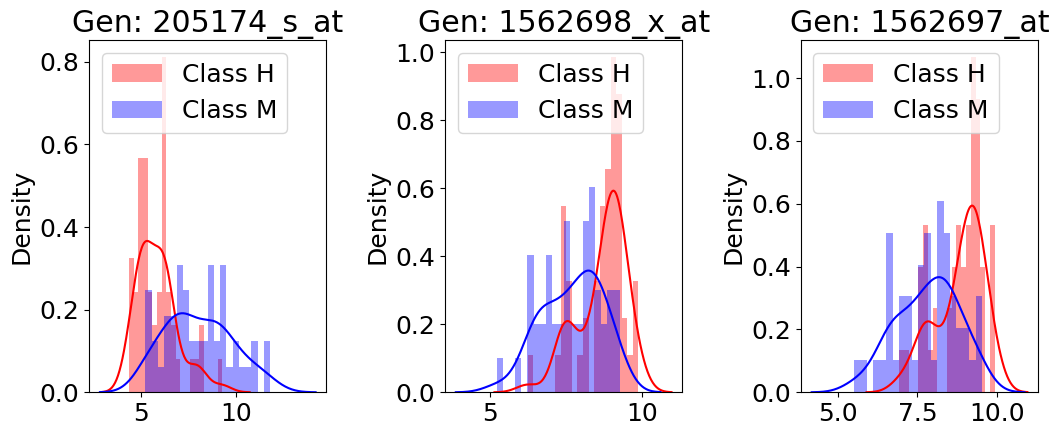

In [ ]:
D3 = D.T.sample(n=3)
D3 = df[D3.index]

cols = D3.columns


fig = plt.figure()
fig.subplots_adjust(top=0.12, bottom=0.01, left=0.0010, right=0.95, hspace=0.5, wspace=0.5)

for idx, col in enumerate(cols, start=1):
    ClassM = D3[D3.columns[idx-1]][M_vector].to_numpy()
    ClassH = D3[D3.columns[idx-1]][H_vector].to_numpy()
    ax = fig.add_subplot(1, 3, idx)
    sns.distplot(ClassH, ax=ax, label='Class H',color='red',bins=20).set_title(f"Gen: {D3.columns[idx-1]}")
    sns.distplot(ClassM, ax=ax, label='Class M',color='blue',bins=20)
    plt.xlabel = "# of Subjects"
    plt.legend(loc = 'upper left') 


In [ ]:
sortedDF = df[['Class', *D]].sort_values(by='Class')

sortedM = sortedDF[sortedDF['Class'] == 'M']
sortedH = sortedDF[sortedDF['Class'] == 'H']



In [ ]:
sortedMeanDiff = (sortedM.iloc[:,1:].astype("float").mean()-sortedH.iloc[:,1:].astype("float").mean()).sort_values()
meanSortedDF = sortedDF.reindex(sortedMeanDiff.index, axis=1)

Text(0.5, 1.0, 'The expression values of genes (y-axis) in D across the entire cohort by subject ID (x-axis)')

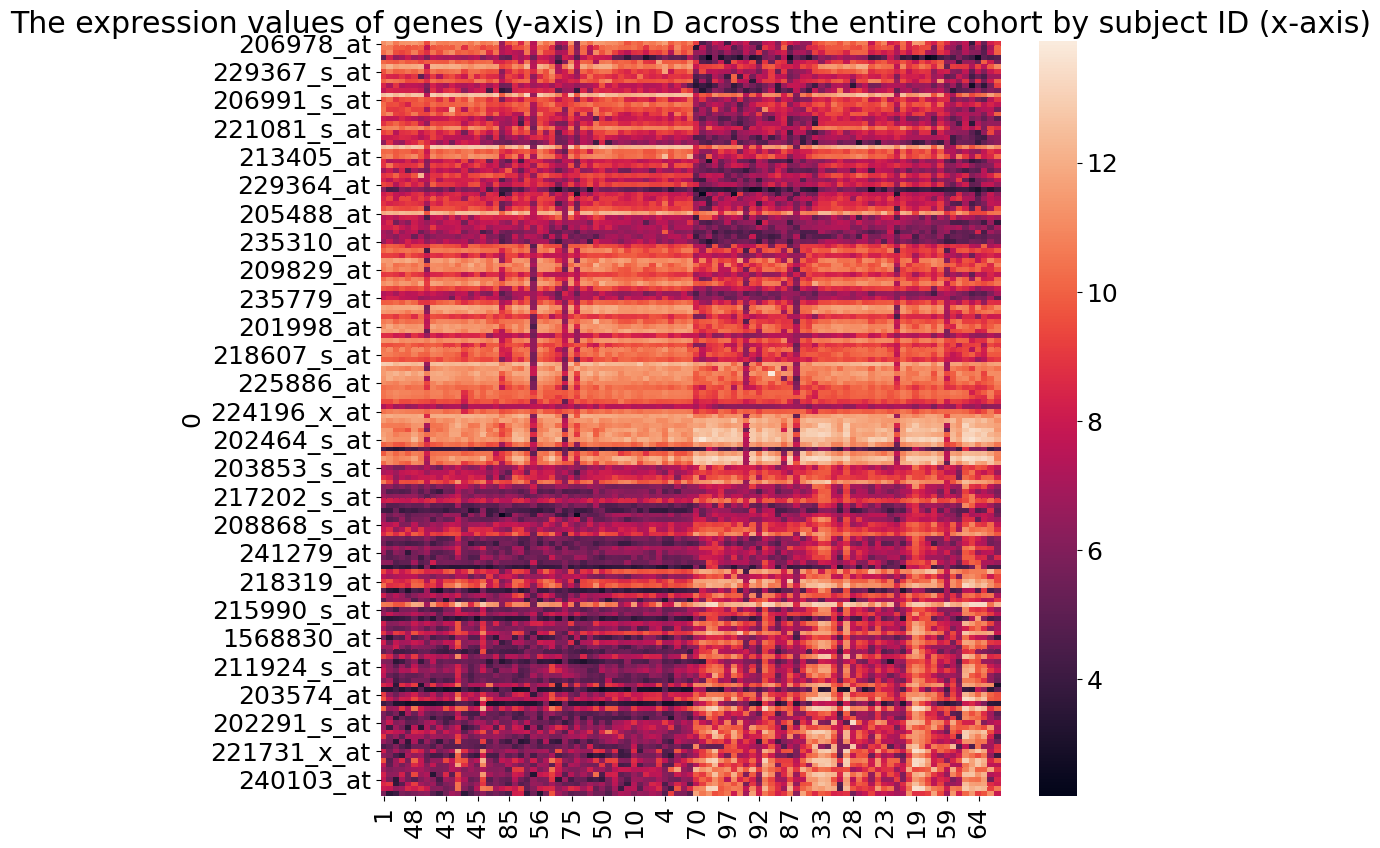

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(meanSortedDF.T.astype("float"), vmin=meanSortedDF.min().min(), vmax=meanSortedDF.max().max())
plt.title('The expression values of genes (y-axis) in D across the entire cohort by subject ID (x-axis)')

